In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

In [6]:
# Generate a plot of MAP from the results in results_csv
def map_plot(results_csv_file, config, experiment_names, title=""):
    folder_path = "./"
    num_turns = config['dialogue_sim']['num_turns']
    results_df = pd.read_csv(results_csv_file)

    # Set up colours
    # import pdb; pdb.set_trace()
    colors = mpl.colormaps['viridis']
    colors = [colors(i) for i in np.linspace(0, 1, len(results_df))]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    for row_num in range(len(results_df)):
        row_maps = []
        upper_bounds = []
        lower_bounds = []
        for turn in range(num_turns):
            row_maps.append(results_df.loc[row_num, 'map@%d' % turn])
            upper_bounds.append(results_df.loc[row_num, 'map@%d_ub' % turn])
            lower_bounds.append(results_df.loc[row_num, 'map@%d_lb' % turn])

        plt.plot(np.linspace(1,num_turns,num_turns), row_maps, marker="o", linestyle="solid", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
        plt.plot(np.linspace(1,num_turns,num_turns), upper_bounds, marker=".", linestyle="--", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
        plt.plot(np.linspace(1,num_turns,num_turns), lower_bounds, marker=".", linestyle="--", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
        plt.fill_between(np.linspace(1,num_turns,num_turns), upper_bounds, lower_bounds, color=colors[row_num], alpha=.1)

    # Set axis labels
    plt.xticks(np.arange(1, num_turns+1, step=1))
    plt.ylabel('MAP')
    plt.xlabel('Turn #')

    # Create a legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(results_df))]
    plt.legend(handles, [exp_name for exp_name in experiment_names], title='Experiments')

    plt.ylim(0,0.3)

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    file_path = os.path.dirname(results_csv_file)
    file_name = os.path.join(file_path, "MAP_plot.png")
    fig.savefig(file_name)

    plt.show()

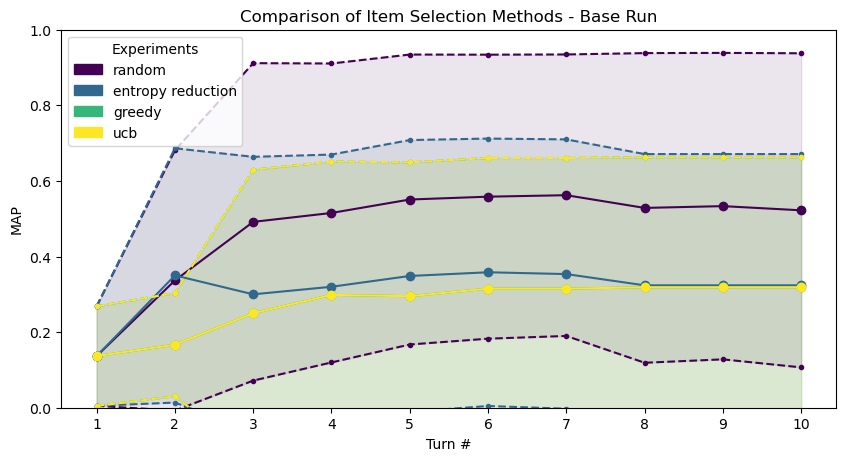

In [25]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/dt_methods_jan_10_base_run/aggregated_results.csv"

experiment_names = ["random", "entropy reduction", "greedy", "ucb"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods - Base Run")

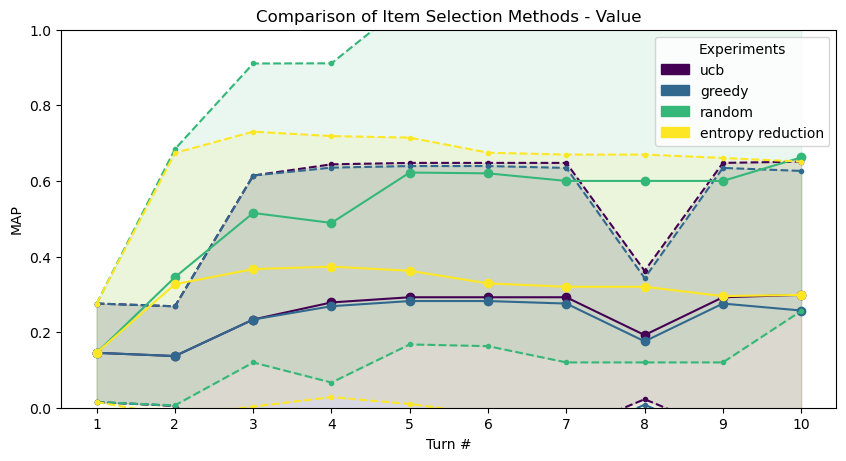

In [26]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/dt_methods_jan_10_value/aggregated_results.csv"

experiment_names = ["ucb", "greedy", "random", "entropy reduction"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods - Value")

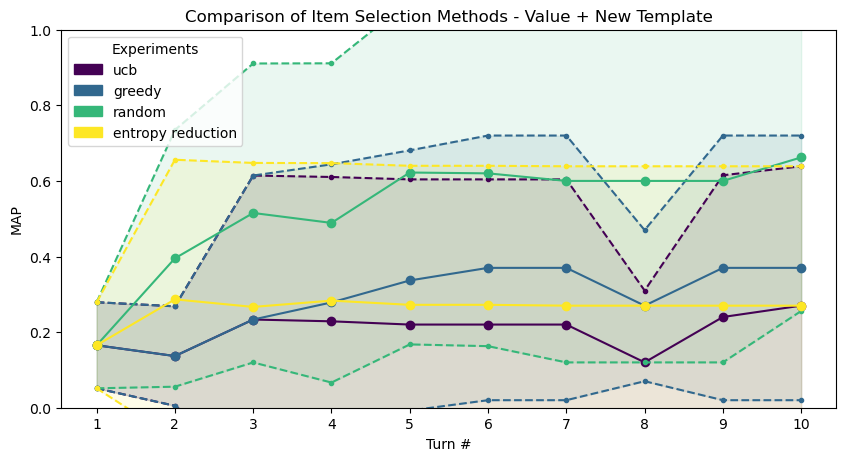

In [27]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/dt_methods_jan_10_value_new_template/aggregated_results.csv"

experiment_names = ["ucb", "greedy", "random", "entropy reduction"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods - Value + New Template")

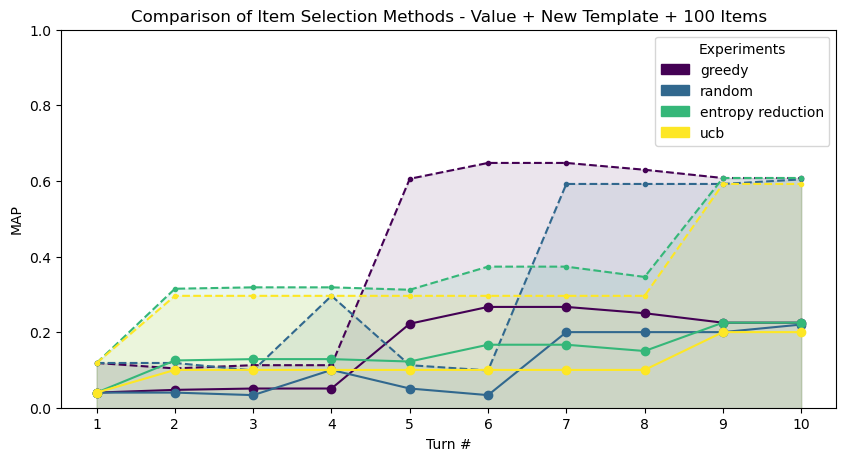

In [28]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/dt_methods_jan_10_value_new_template_100_items/aggregated_results.csv"

experiment_names = ["greedy", "random", "entropy reduction", "ucb"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods - Value + New Template + 100 Items")

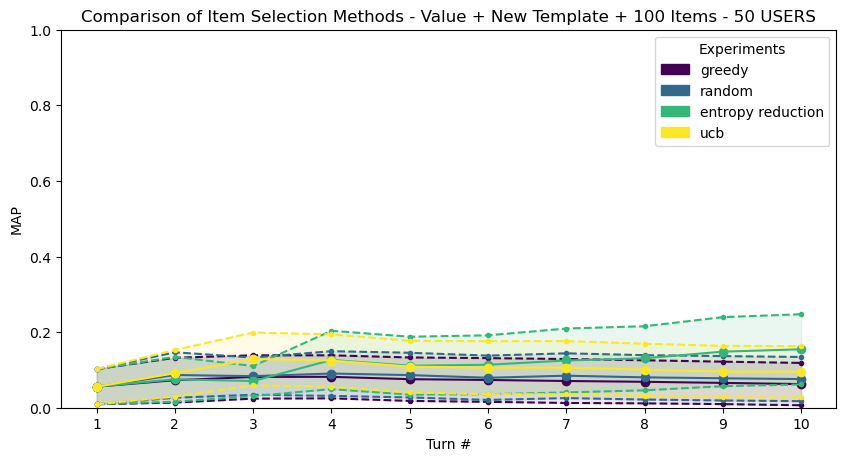

In [3]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/dt_methods_jan_10_value_new_template_100_items_50_users/aggregated_results.csv"

experiment_names = ["greedy", "random", "entropy reduction", "ucb"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods - Value + New Template + 100 Items - 50 USERS")

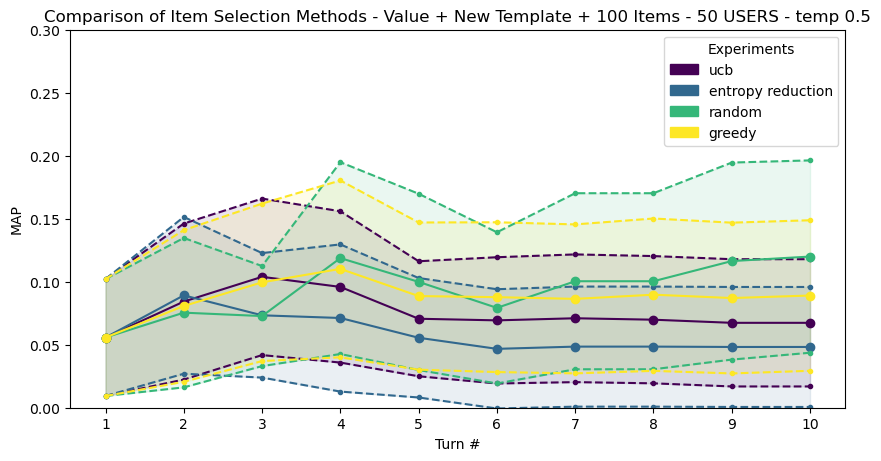

In [34]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/dt_methods_jan_10_value_new_template_100_items_50_users_temp_0p5/aggregated_results.csv"

experiment_names = ["ucb", "entropy reduction", "random", "greedy"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods - Value + New Template + 100 Items - 50 USERS - temp 0.5")

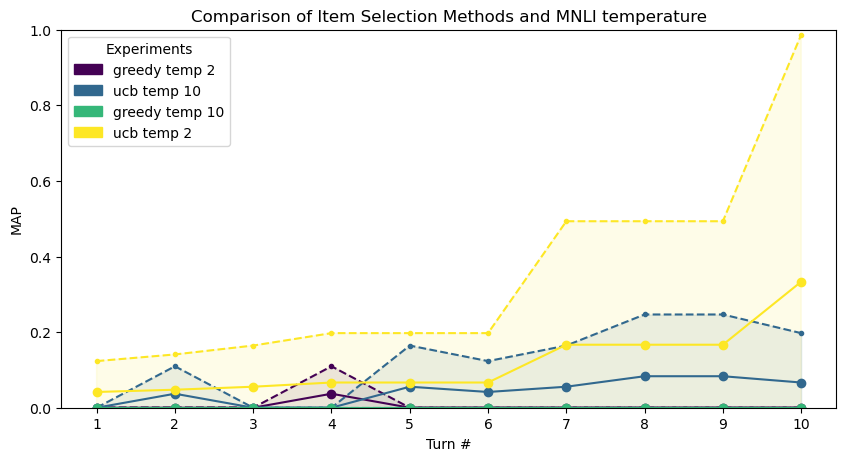

In [52]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/jan_11_temp_3_users/aggregated_results.csv"

experiment_names = ["greedy temp 2", "ucb temp 10", "greedy temp 10", "ucb temp 2"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods and MNLI temperature")

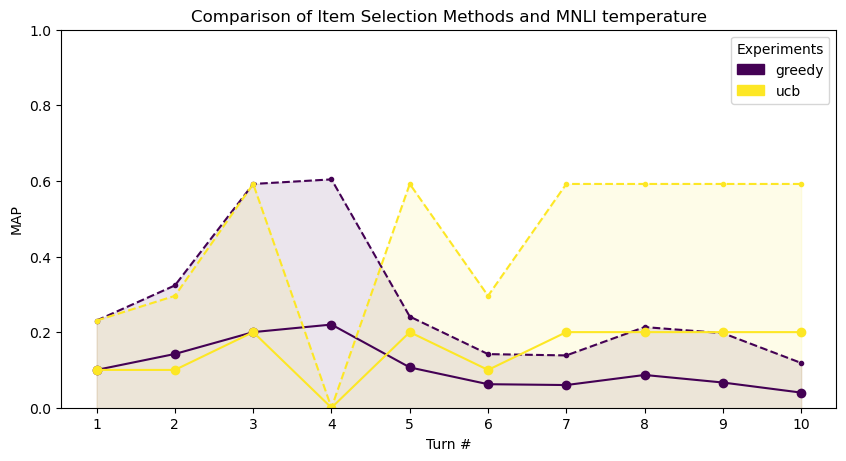

In [53]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/jan_11_temp_5_users/aggregated_results.csv"

experiment_names = ["greedy", "ucb"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods and MNLI temperature")

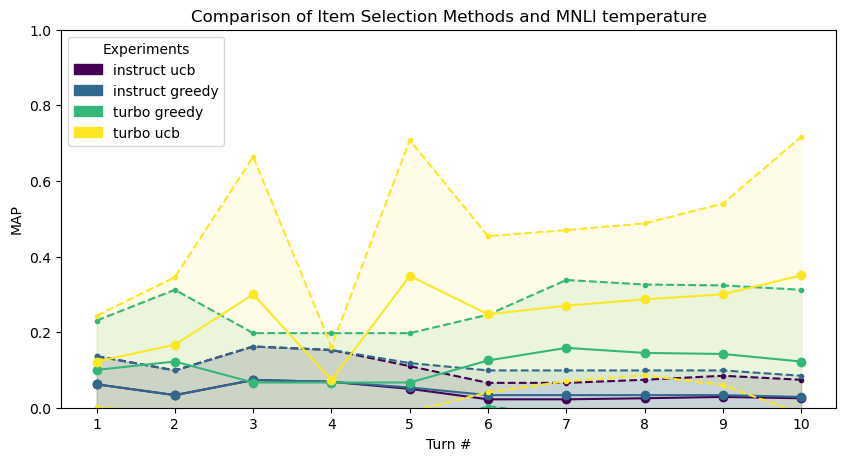

In [56]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/jan_11_5_users_llm_comparison/aggregated_results.csv"

experiment_names = ["instruct ucb", "instruct greedy", "turbo greedy", "turbo ucb"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods and MNLI temperature")

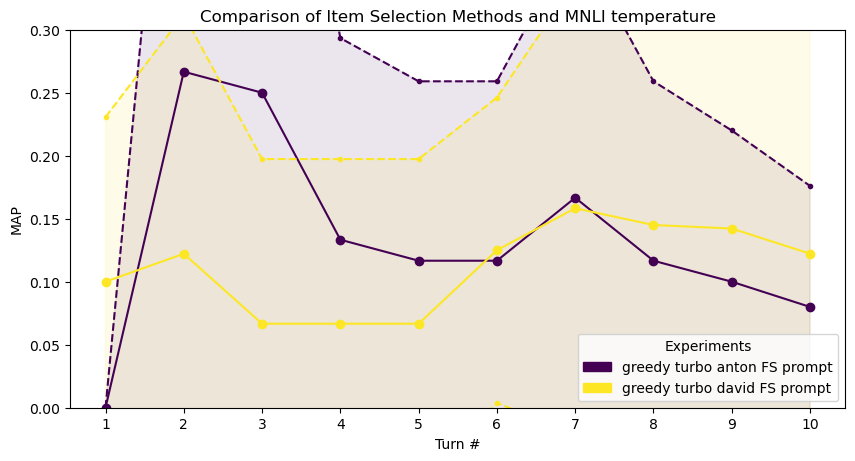

In [7]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/jan_11_5_users_llm_comparison_anton_FS/aggregated_results.csv"

experiment_names = ["greedy turbo anton FS prompt", "greedy turbo david FS prompt"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods and MNLI temperature")

In [ ]:
config = {'dialogue_sim': {'num_turns': 10}}
results_csv_file = "experiments/jan_11_5_users_pre_random_seed/aggregated_results.csv"

experiment_names = ["greedy", "ucb"]
map_plot(results_csv_file, config, experiment_names, "Comparison of Item Selection Methods and MNLI temperature")

In [45]:
# Generate a plot of MAP from the results in results_csv
def double_map_plot(results_csv_files, configs, experiment_names_list, title=""):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.title(title)

    total_counter = 0
    all_exp_names = []
    for experiment_names in experiment_names_list:
        for exp_name in experiment_names:
            all_exp_names.append(exp_name)

    for i in range(len(results_csv_files)):
        config = configs[i]
        experiment_names = experiment_names_list[i]
        results_csv_file = results_csv_files[i]
        folder_path = "./"
        num_turns = config['dialogue_sim']['num_turns']
        results_df = pd.read_csv(results_csv_file)

        # Set up colours
        # import pdb; pdb.set_trace()
        colors = mpl.colormaps['viridis']
        colors = [colors(i) for i in np.linspace(0, 1, len(all_exp_names))]
        
        for row_num in range(len(results_df)):
            row_maps = []
            upper_bounds = []
            lower_bounds = []
            for turn in range(num_turns):
                row_maps.append(results_df.loc[row_num, 'map@%d' % turn])
                upper_bounds.append(results_df.loc[row_num, 'map@%d_ub' % turn])
                lower_bounds.append(results_df.loc[row_num, 'map@%d_lb' % turn])

            plt.plot(np.linspace(1,num_turns,num_turns), row_maps, marker="o", linestyle="solid", color=colors[total_counter], label=results_df.loc[row_num, 'Experiment Name'])
            # plt.plot(np.linspace(1,num_turns,num_turns), upper_bounds, marker=".", linestyle="--", color=colors[total_counter], label=results_df.loc[row_num, 'Experiment Name'])
            # plt.plot(np.linspace(1,num_turns,num_turns), lower_bounds, marker=".", linestyle="--", color=colors[total_counter], label=results_df.loc[row_num, 'Experiment Name'])
            # plt.fill_between(np.linspace(1,num_turns,num_turns), upper_bounds, lower_bounds, color=colors[total_counter], alpha=.1)
            total_counter += 1

    # Set axis labels
    plt.xticks(np.arange(1, num_turns+1, step=1))
    plt.ylabel('MAP')
    plt.xlabel('Turn #')

    # Create a legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(all_exp_names))]
    plt.legend(handles, [exp_name for exp_name in all_exp_names], title='Experiments') #TODO: Combine exp names from all lists

    plt.ylim(0,0.3)

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    file_path = os.path.dirname(results_csv_file)
    file_name = os.path.join(file_path, "MAP_plot.png")
    fig.savefig(file_name)

    plt.show()

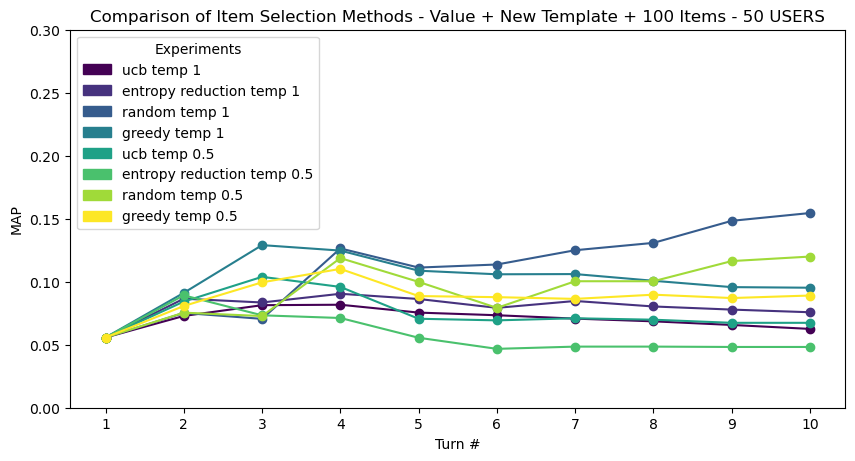

In [49]:
configs = [{'dialogue_sim': {'num_turns': 10}}, {'dialogue_sim': {'num_turns': 10}}]
results_csv_files = ["experiments/dt_methods_jan_10_value_new_template_100_items_50_users/aggregated_results.csv", "experiments/dt_methods_jan_10_value_new_template_100_items_50_users_temp_0p5/aggregated_results.csv"]

experiment_names_list = [["ucb temp 1", "entropy reduction temp 1", "random temp 1", "greedy temp 1"], ["ucb temp 0.5", "entropy reduction temp 0.5", "random temp 0.5", "greedy temp 0.5"]]
double_map_plot(results_csv_files, configs, experiment_names_list, "Comparison of Item Selection Methods - Value + New Template + 100 Items - 50 USERS")